# Burnt area mapping using Sentinel-2 Near Real Time data  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently only compatible with `DEA Sandbox` environment as near real time data is not available on the NCI
* **Products used:** 
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background

### Normalized Burn Ratio

\begin{equation}
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\end{equation}

NBR returns values between -1 and 1. 
**Healthy green vegetation will have a high NBR value while burnt vegetation will have a low value**. 
Areas of dry, brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalized Burn Ratio

Change in Normalized Burn Ratio - also called Delta Normalized Burn Ratio (dNBR) - is calculated by subtracting the post-fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
dNBR = NBR_{baseline} - NBR_{post fire}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what is burnt as it shows change from the baseline state. 
**A burnt area will have a positive dNBR value** while an unburnt area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity). 
A higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowledge portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

### Defining Burnt From Unburnt Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropriate for differentiating burnt from unburnt areas when using Sentinel-2. 
However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

Some care should also be taken when interpreting results as a number of possible false positives can return a positive dNBR result:

* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burnt
* Drying out of bright green vegetation such as grasses. 
If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burnt.


## Description

This notebook calculates the change in Normalized Burn Ratio between a baseline composite image of the pre-fire condition of a selected area and a post-fire event image, in order to find burnt area extent. 
**Specifically this notebook has been designed for mapping fire extent in recent fires, and so assumes that NRT products will need to be used. If the fire of interest is historical, users should select the definitive Sentinel-2 Analysis Ready Product instead.**
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. 
The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. 
The code in this notebook will automatically generate the composite image over the set length of time using both Sentinel-2 Near Real Time data and the definitive Sentinel 2 Analysis Ready Product.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [2]:
import datacube
from datacube.utils import cog
from datetime import datetime
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="SnowGum")

In [4]:
client = create_local_dask_cluster(return_client=True)

Client Scheduler: tcp://127.0.0.1:36355 Dashboard: /user/mickwelli/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [6]:
# Set the central latitude and longitude
central_lat = -36.992
central_lon = 148.3986

# Set the buffer to load around the central coordinates
buffer = 0.05

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

#### Define load parameters

In [8]:
time = ('2021-01-01', '2021-12-31')
resolution = (-10, 10)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir_1', 'nbart_swir_3']
min_gooddata = 0.5
output_crs = 'EPSG:3577'

## Load all baseline data

In [9]:
snowgum_ard = load_ard(dc=dc,
                       products=['s2a_ard_granule', 's2b_ard_granule'],
                       x=study_area_lon,
                       y=study_area_lat,
                       time=time,
                       measurements=measurements,
                       min_gooddata=min_gooddata,
                       output_crs=output_crs,
                       resolution=resolution,
                       group_by='solar_day',
                       dask_chunks = {"time": 1, "x": 3000, "y": 3000})

/home/jovyan/Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 40 out of 144 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Returning 40 time steps as a dask array


## Generate Normalized Burn Ratio for baseline period

In [ ]:
# Calculate NBR for the baseline images
snowgum_indices = calculate_indices(snowgum_ard, 
                             index=['NDVI', 'EVI', 'NBR'], 
                             collection='ga_s2_1', 
                             drop=False)

# Compute median using all observations in the dataset along the time axis
snowgum_median = snowgum_indices.median(dim='time')


Plot the baseline NBR data side-by-side with an RGB plot of the study area:

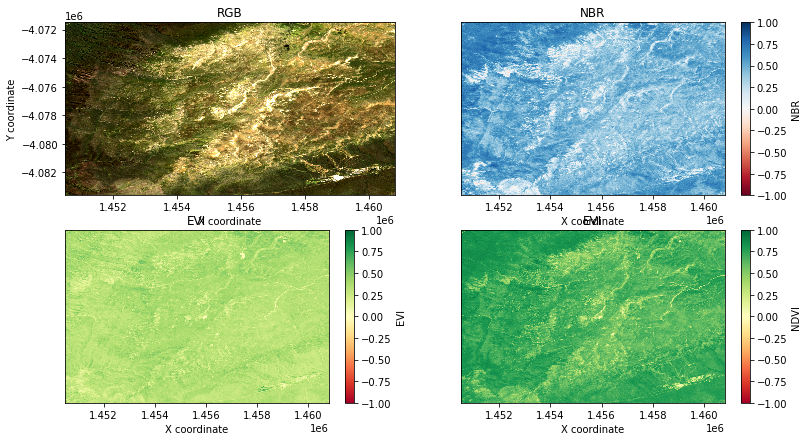

In [11]:
# Set up subplots
f, axarr = plt.subplots(2, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(snowgum_median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
snowgum_median.NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

snowgum_median.EVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=axarr[1, 0])
axarr[1, 0].set_title('EVI')
axarr[1, 0].yaxis.set_visible(False)
axarr[1, 0].set_xlabel('X coordinate');

snowgum_median.NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=axarr[1, 1])
axarr[1, 1].set_title('NDVI')
axarr[1, 1].yaxis.set_visible(False)
axarr[1, 1].set_xlabel('X coordinate');

## Export results to GeoTIFF

The baseline reference image and the post fire image will both be saved as a multiband GeoTIFF with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The thresholded burnt area image will be saved as a single band image, where a value of 1 = burnt and a value of 0 = not burnt.

In [13]:
# Define an area name to be used in saved file names
area_name = 'Snowgum'

# Write to multi-band GeoTIFF
cog.write_cog(snowgum_median.NBR, f'{area_name}_NBR_image.tif', overwrite=True)
cog.write_cog(snowgum_median.EVI, f'{area_name}_EVI_image.tif', overwrite=True)
cog.write_cog(snowgum_median.NDVI, f'{area_name}_NDVI_image.tif', overwrite=True)

Delayed('_write_cog-cff2a1c0-257f-4d55-a26f-293fc94dc53e')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)